In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [194]:
train_path = '../data/tiantic/train.csv'
test_path = '../data/tiantic/test.csv'

data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

In [220]:
def plot_confusion_matrix(matrix, classes, title="Confusion Matrix", cmap=plt.cm.Blues):
    plt.imshow(matrix, interpolation='nearest', cmap=cmap) #interpolation: 把某块显示成一种颜色
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    thresh = matrix.max() / 2.
    
    #plt.xticks : 第一个数组参数是标示的位置，第二个数组是标示的文字
    plt.xticks(tick_marks, classes) 
    plt.yticks(tick_marks, classes)
    for y in range(len(matrix)):
        for x in range(len(matrix[0])):
            plt.text(x, y, matrix[y,x]
                    ,horizontalalignment="center" 
                    ,color="white" if matrix[y,x] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## 数据预处理

In [202]:
def preprocess(data):
    # 填充空数据
    data['Age'] = data['Age'].fillna(data['Age'].median())
    data['Embarked'] = data['Embarked'].fillna('S')
    data['Fare'] = data['Fare'].fillna(data['Fare'].median())

    # 将年龄转换字符型为数字型
    data.loc[data['Sex'] == 'male', 'Sex'] = 0
    data.loc[data['Sex'] == 'female', 'Sex'] = 0
    data.loc[data['Embarked'] == 'S', 'Embarked'] = 0
    data.loc[data['Embarked'] == 'Q', 'Embarked'] = 1
    data.loc[data['Embarked'] == 'C', 'Embarked'] = 2
preprocess(data)
preprocess(test_data)

### 线性回归与逻辑回归模型预测

In [212]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix

In [192]:
lr_features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
x_data = data.loc[:, lr_features]
y_data = data['Survived']

# 划分训练集与测试集
lr_x_train, lr_x_test, lr_y_train, lr_y_test = train_test_split(lr_x_data, lr_y_data, test_size=0.2)

# 交叉验证
kf = KFold(n_splits=5, random_state=42)
lr_accuracies = []
lgr_accuracies = []

lr = LinearRegression()
lgr = LogisticRegression(C=10, penalty='l2', solver='liblinear')
    
for train, test in kf.split(lr_x_train):
    lr.fit(lr_x_train.iloc[train, :], lr_y_train.iloc[train])
    lgr.fit(lr_x_train.iloc[train, :], lr_y_train.iloc[train])
    
    lr_predict = lr.predict(lr_x_train.iloc[test, :])
    lgr_predict = lgr.predict(lr_x_train.iloc[test, :])
    
    lr_predictions = np.zeros(len(lr_predict))
    lr_predictions[lr_predict > 0.5] = 1
    
    lr_accuracy = accuracy_score(lr_y_train.iloc[test].values, lr_predictions)
    lgr_accuracy = accuracy_score(lr_y_train.iloc[test].values, lgr_predict)
    
    lr_accuracies.append(lr_accuracy)
    lgr_accuracies.append(lgr_accuracy) 
    
    
print('线性回归算法精确度：%.3f' % np.mean(lr_accuracies))
print('逻辑回归算法精确度：%.3f' % np.mean(lgr_accuracies))

线性回归算法精确度：0.708
逻辑回归算法精确度：0.706


In [190]:
lr.fit(lr_x_train, lr_y_train)
lgr.fit(lr_x_train, lr_y_train)

lr_predictions_proba = lr.predict(lr_x_test)
lr_predictions = np.zeros(len(lr_predictions_proba))
lr_predictions[lr_predictions_proba > 0.5] = 1

lgr_predictions = lgr.predict(lr_x_test)

lr_accuracy = accuracy_score(lr_y_test, lr_predictions)
lgr_accuracy = accuracy_score(lr_y_test, lgr_predictions)

print('线性回归算法精确度：%.4f' % np.mean(lr_accuracy))
print('逻辑回归算法精确度：%.4f' % np.mean(lgr_accuracy))

线性回归算法精确度：0.6983
逻辑回归算法精确度：0.7263


### 随机森林

In [158]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

 **min_samples_leaf**：这个值限制了叶子节点最少的样本数，如果某叶子节点数目小于样本数，则会和兄弟节点一起被剪枝。 默认是1,可以输入最少的样本数的整数，或者最少样本数占样本总数的百分比。如果样本量不大，不需要管这个值。如果样本量数量级非常大，则推荐增大这个值。之前的10万样本项目使用min_samples_leaf的值为5，仅供参考。

**min_samples_split**：这个值限制了子树继续划分的条件，如果某节点的样本数少于min_samples_split，则不会继续再尝试选择最优特征来进行划分。 默认是2.如果样本量不大，不需要管这个值。如果样本量数量级非常大，则推荐增大这个值。我之前的一个项目例子，有大概10万样本，建立决策树时，我选择了min_samples_split=10。可以作为参考。

0.7239407444604857
精度： 0.856341189674523


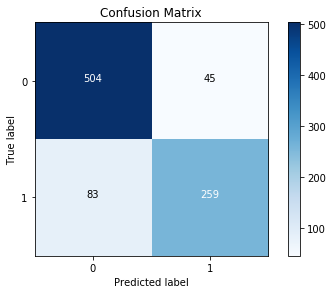

In [218]:
rfc = RandomForestClassifier(random_state=1, n_estimators=55, min_samples_leaf=2, min_samples_split=2)

kf = KFold(5)

course = cross_val_score(rfc, x_data, y_data, cv=kf)
print(np.mean(course))

rfc.fit(x_data, y_data)
predict = rfc.predict(x_data)
score = accuracy_score(y_data.values.ravel(), predict)

cm = confusion_matrix(y_data.values.ravel(), predict)
plot_confusion_matrix(cm, classes=[0,1])
print("精度：", score)


### 自动特征选择

In [221]:
from sklearn.feature_selection import SelectKBest, f_classif

In [222]:
selector = SelectKBest(f_classif, k='all')

In [223]:
selector.fit(x_data, y_data)


/Users/zheng/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [1] are constant.
  UserWarning)
/Users/zheng/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


SelectKBest(k='all', score_func=<function f_classif at 0x1a10e5d268>)

In [224]:
selector.scores_

array([115.03127219,          nan,   3.76152805,   1.1105722 ,
         5.96346384,  63.03076423,  25.71728646])

In [225]:
len(lr_features)

7

In [226]:
lr_features

['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']